In [1]:
%matplotlib inline

# misc. libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# ml libraries
from sklearn import cluster, metrics
from sklearn.decomposition import PCA

import inspect

%load_ext autoreload
%autoreload 2

In [38]:
# local dependencies
from load import *
from helpers import *
from plots import *
from constants import *

**General notes**
* The aim is to find out if the tumor is responding to a specific hormone. This response is "induced" in mice by treating them with the hormone. In humans we try to find similar expression patterns to determine if the tumor is driven by a certain hormone. In which case we can group such tumors together for more targeted and better treatment. We know that the patients have a certain type of cancer and this is recorded somewhere although we don't have this information now. If we discover a clear clustering, then it will be valuable to see which cancer types each data point (patient) has. If we interpret each cluster as being certain type of cancer instead of a hormone response, then we will misinterpret the results since the genetic expressions (features) are not results
* [Patient derived xenograft, Wikipedia](https://en.wikipedia.org/wiki/Patient_derived_xenograft)
* [Few useful things to know about ML](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
* Useful magics:
  * `%pycat <filename>` to show a syntax-highlighted file
  * `%psource <object>` prints the source code for an object (function, for instance)

**Notes from Fabio**
* The data include: a matrix from our PDX models stimulated with different hormones (estrogen, progesterone and testosterone) - from which I estimated a list of differentially expressed genes to interrogate the patients' datasets - and a matrix from breast cancer patients retrieved from the TCGA (the Cancer Genome Atlas Consortium - published data).
* I suggest you to start testing the list of differentially expressed genes on your training data (PDXs, which is labelled with the correct treatment) that you can use as positive control in order to test the performance of your methods (you can estimate the sensitivity and specificity of the methods that you want to use, so that we can have an idea of which method should be in principle better to use in the patients dataset). Once you will be able to correctly discriminate the samples in the training set, then you can start interrogating the patients' matrix.
* Keep in mind that one of the early things that we do when dealing with sequencing data is to get rid of genes that show no or "minor" expression overall in the dataset. This means that, for those genes that do not reach a given threshold of expression in a number of patients, they are simply excluded from the analysis because they are supposedly not informative and just confounding the further analysis. Therefore, to some degree, we should expect to have differences in the genes that are expressed. 
* Regarding the patients data I already gave you they should be already normalized, whereas the new patients' dataset that you downloaded from the Internet  you should make sure it is correctly normalized (for this you should more or less have a normal distribution of your counts and more or less the samples - columns- should have a similar number of counts) and then run the analysis. However, I the interpretation of the PCA plot will not be trivial: since these are patients samples they are likely to be heterogeneous and therefore I do not expect to have a clear clustering of the samples based on their cancer type.
* [Informations about drugs used to treat breast cancer](https://www.nature.com/articles/d41573-019-00201-w) over the last decades, to give you an idea of the need for a more personalized medicine.
* [Small review on personalized medicine and why it should be pursued](https://notendur.hi.is/~vol1/pdx-papers/nejmsb1503104.pdf)
* [Patient-derived xenograft models of breast
cancer and their predictive power](https://notendur.hi.is/~vol1/pdx-papers/2015%20PDX%20Breast%20Cancer%20Research.pdf)
* [A paper from our lab in which there is the description of our PDX (Patient-Derived Xenograft) model - your training dataset](https://notendur.hi.is/~vol1/pdx-papers/2016%20MIND%20for%20Breast%20Cancer%20Sflomos%20Cancer%20Cell.pdf)

+ **DHT:** Dihydrotestosterone is an endogenous androgen sex steroid and hormone
+ **E2:** Estradiol (E2), also spelled oestradiol, is an estrogen steroid hormone and the major female sex hormone
+ **P4:**  Progesterone (P4) is an endogenous steroid and progestogen sex hormone involved in the menstrual cycle, pregnancy, and embryogenesis of humans and other species

***
**Data loading and manipulation**
***

In [3]:
%psource load_genes

def load_genes():
    """Load raw information about the genes"""
    pkl = f"{DATA_DIR}/genes_raw.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        columns = [(i, j) for i in HORMONES for j in UP_DOWN]
        multi_index = pd.MultiIndex.from_tuples(columns)

        genes = pd.read_excel(
            GENES_PATH,
            names=multi_index,
            skiprows=[0, 1],
            usecols=[1, 2, 4, 5, 7, 8],
        )
        genes.to_pickle(pkl)
        return genes


In [4]:
# Raw information about genes
genes = load_genes()
genes

dht                 e2                      p4          
          up      down       up        down          up      down
0       KLK3      CPB1      NTS        CPB1        KLK3     RAB31
1       GPC3    CITED1      DCX  AC062028.2      CXCL13       PGR
2      GPR88     GRIK3  COL22A1      SPINK4        DIO2  FLNB-AS1
3    UGT2B11      LYG1    IGSF1       POTEJ         TAT     ZNF71
4       KLK2     DCDC2   NECAB1         ALB     ADAMTS8    ZNF282
5    UGT2B28   ZNRF2P1   PIEZO2       MS4A7      MYBPC1    QRICH1
6    SLC26A3      CISH     TP63      PLA2G3     UGT2B11       NaN
7   TMEM176A    ZNF107  TMPRSS4     CACNA1H       NTRK3       NaN
8       HPGD       GHR    KLK12    CYP4F30P        DLC1       NaN
9     CYP4F8    NFKBIE     HPGD      MS4A14      ABCA13       NaN
10     DHRS2   FAM217B    KLK14    CYP4F29P      GIMAP6       NaN
11    ATP1A2     GFOD1  SCGB3A1      KLF2P3     SLC26A3       NaN
12    TSPAN8     RIPK2    KCNK3       PEX5L       PDE2A       NaN
13   ALOX15B   TNFAIP3    NTRK3       TPSG1     SPARCL1       NaN
14   HSD17B2  TMEM106B     NEFH       NELL2      SYNPO2       NaN
15    COL3A1    FAM92A    GRIK4      FAR2P3       LAMA1       NaN
16   RANBP3L     BICD1    OLFM4    CYP4F62P      CLEC7A       NaN
17      SOX2      FGD6    RFLNA      CRTAC1  AL591034.3       NaN
18    MYBPC1    FAM83B   RUBCNL      SORCS1      ZBTB16       NaN
19    CXCL13   PLEKHO1    GREB1   SOCS2-AS1     ADAMTS1       NaN
20     FGFR4   MAP3K14  SLC34A2     BPIFA4P      PKD1L1       NaN
21   COL12A1      PER2     SDC2        CSTA       CYYR1       NaN

In [5]:
# Preprocessed list of genes
genes_list = load_genes_list()
genes_list.head(2)

,genes,dht,e2,p4,upregulated
0,ABCA13,False,False,True,True
1,AC062028.2,False,True,False,False


In [6]:
# Genes showing response to two hormones
genes_list[genes_list[["dht", "e2", "p4"]].sum(axis=1) == 2]

,genes,dht,e2,p4,upregulated
17,CPB1,True,True,False,False
20,CXCL13,True,False,True,True
46,HPGD,True,True,False,True
54,KLK3,True,False,True,True
60,MYBPC1,True,False,True,True
65,NTRK3,False,True,True,True
85,SLC26A3,True,False,True,True
101,UGT2B11,True,False,True,True


In [7]:
# Load TCGA first tumor-patients dataset
patients = load_patients()

In [8]:
# Load TCGA second tumor-patients dataset
patients2 = load_patients2()

Not all the genes are expressed in every cell of patients and within a broad set of samples, so we discard genes not expressed in the patients datasets. This is what is to be expected, especially when taking into account that we are comparing data on human patients with data from a xenograft experiment. Let's list the genes that were not found:

In [9]:
genes_not_found = genes_list.genes[~genes_list.genes.isin(patients.columns)]
print(f"Genes not found in the patients datasets:\n\n{list(genes_not_found)}")

Genes not found in the patients datasets:

['AC062028.2', 'AL591034.3', 'BPIFA4P', 'CYP4F29P', 'CYP4F30P', 'CYP4F62P', 'FAM217B', 'FAM92A', 'FAR2P3', 'FLNB-AS1', 'KLF2P3', 'PIEZO2', 'POTEJ', 'RFLNA', 'RUBCNL', 'SOCS2-AS1', 'ZNRF2P1']


In [10]:
genes_expressed = patients.columns
print(f"Genes found in the patients datasets:\n\n{list(genes_expressed)}")

Genes found in the patients datasets:

['ABCA13', 'ADAMTS1', 'ADAMTS8', 'ALB', 'ALOX15B', 'ATP1A2', 'BICD1', 'CACNA1H', 'CISH', 'CITED1', 'CLEC7A', 'COL12A1', 'COL22A1', 'COL3A1', 'CPB1', 'CRTAC1', 'CSTA', 'CXCL13', 'CYP4F8', 'CYYR1', 'DCDC2', 'DCX', 'DHRS2', 'DIO2', 'DLC1', 'FAM83B', 'FGD6', 'FGFR4', 'GFOD1', 'GHR', 'GIMAP6', 'GPC3', 'GPR88', 'GREB1', 'GRIK3', 'GRIK4', 'HPGD', 'HSD17B2', 'IGSF1', 'KCNK3', 'KLK12', 'KLK14', 'KLK2', 'KLK3', 'LAMA1', 'LYG1', 'MAP3K14', 'MS4A14', 'MS4A7', 'MYBPC1', 'NECAB1', 'NEFH', 'NELL2', 'NFKBIE', 'NTRK3', 'NTS', 'OLFM4', 'PDE2A', 'PER2', 'PEX5L', 'PGR', 'PKD1L1', 'PLA2G3', 'PLEKHO1', 'QRICH1', 'RAB31', 'RANBP3L', 'RIPK2', 'SCGB3A1', 'SDC2', 'SLC26A3', 'SLC34A2', 'SORCS1', 'SOX2', 'SPARCL1', 'SPINK4', 'SYNPO2', 'TAT', 'TMEM106B', 'TMEM176A', 'TMPRSS4', 'TNFAIP3', 'TP63', 'TPSG1', 'TSPAN8', 'UGT2B11', 'UGT2B28', 'ZBTB16', 'ZNF107', 'ZNF282', 'ZNF71']


Let's now load the patient derived xenograft (PDX) experiment data:

In [11]:
pdx = load_pdx()
pdx

label    ABCA13   ADAMTS1   ADAMTS8       ALB  \
treatment id                                                            
dht       t111_g2_m09       0  3.189617  7.923171  8.423222  7.117144   
          t111_g2_m06       0  6.357327  6.265651  8.954985  5.686476   
          t111_g2_m02       0  7.431527  3.189617  8.053738  3.189617   
e2        pl015_g3_m25      1  8.587668  6.596610  3.505313  6.296377   
          pl015_g3_m26      1  9.324330  6.446981  3.486839  6.809062   
          t111_g2_m12       1  3.189617  8.261285  4.067052  7.135662   
          t111_g2_m10       1  3.189617  8.123383  5.090788  6.832405   
          pl015_g3_m33      1  9.199594  6.445167  3.454762  6.713023   
          t111_g2_m03       1  3.720257  7.944536  3.720257  6.965014   
          pl015_g3_m39      1  9.294185  6.773938  3.537989  6.826193   
          t110_g2_m03       1  4.356682  7.323568  4.356682  6.371492   
          t110_g2_m09       1  4.003272  7.415500  3.663498  6.317940   
p4        t111_g2_m07       2  4.952603  8.349276  3.189617  7.867793   
          t110_g2_m13       2  4.020601  8.783362  5.573343  7.826414   
          t110_g2_m12       2  3.930006  7.727165  3.189617  6.855164   
          t111_g2_m14       2  3.189617  8.530438  6.727036  7.136019   
          t110_g2_m07       2  4.358385  7.250619  3.189617  6.117625   
          t110_g2_m05       2  6.219832  6.813742  3.189617  6.285417   
          pl015_g3_m38      2  6.748741  6.187470  3.622165  6.465449   
          pl015_g3_m35      2  6.076085  6.314754  3.506722  6.409053   
          pl015_g3_m29      2  5.938799  6.386381  3.439497  6.261251   
          pl015_g3_m28      2  6.957474  6.553337  3.489893  6.290409   
          t111_g2_m15       2  3.189617  8.628380  6.111433  7.388242   
ctrl      t110_g2_m08       3  4.200587  7.850492  3.189617  6.909526   
          t110_g2_m02       3  4.606720  7.594579  3.189617  6.933231   
          t110_g2_m01       3  4.546672  7.605361  3.189617  6.704684   
          t111_g2_m01       3  3.923264  8.454011  3.189617  7.343175   
          pl015_g3_m40      3  7.517644  6.828822  3.572844  6.556117   
          t111_g2_m05       3  3.189617  7.996140  4.218945  7.896853   
          pl015_g3_m36      3  7.061650  6.456036  3.453102  6.450958   
          t111_g2_m08       3  3.189617  8.061174  5.707287  8.082403   
          pl015_g3_m31      3  5.868254  6.578944  3.189617  6.178456   
          t110_g2_m06       3  5.474309  7.156082  3.189617  6.570811   

                         ALOX15B    ATP1A2      BICD1   CACNA1H      CISH  \
treatment id                                                                
dht       t111_g2_m09   3.614543  3.189617   5.325093  7.794179  7.166217   
          t111_g2_m06   4.232740  3.189617   6.872338  8.818340  9.442043   
          t111_g2_m02   3.189617  3.189617   8.053738  6.306352  7.145168   
e2        pl015_g3_m25  5.397508  5.299416  10.393886  4.487468  3.955433   
          pl015_g3_m26  5.457619  5.264027  10.574636  3.816297  4.092530   
          t111_g2_m12   4.197837  3.189617   8.933856  3.701361  3.189617   
          t111_g2_m10   4.242212  3.189617   9.171094  4.994560  4.135097   
          pl015_g3_m33  5.670032  5.847867  10.790391  3.647582  3.932384   
          t111_g2_m03   4.550471  3.189617   8.666252  4.793278  3.189617   
          pl015_g3_m39  5.134321  5.801672  10.514098  3.881409  4.268621   
          t110_g2_m03   3.429171  6.330886   8.881589  3.939553  3.429171   
          t110_g2_m09   3.856841  6.336023   9.357093  3.856841  3.189617   
p4        t111_g2_m07   3.189617  3.189617   7.424828  6.560692  3.189617   
          t110_g2_m13   3.836790  3.189617   5.721484  4.502378  5.266335   
          t110_g2_m12   3.189617  6.341278   4.917939  3.189617  3.930006   
          t111_g2_m14   3.189617  3.189617   6.537253  4.371533  5.612173   
          t110_g2_m07   3.189617  6.362277   6.624916  3.189617  3.189617   
     

***
**Exploratory data analysis**
***

Let's investigate how correlated features are among each other in the first patients dataset. We shall plot a heatmap to visualize the lower triangular Pearson correlation matrix.

In [12]:
%psource df_to_tril

def df_to_tril(df):
    """Returns a lower triangular dataframe where entries
    above and including the main diagonal are set to zero.
    """
    for index, row in df.iterrows():
        row[index <= row.index] = 0
    return df


In [13]:
patients_corr = df_to_tril(patients.corr())

In [14]:
# %pycat plots

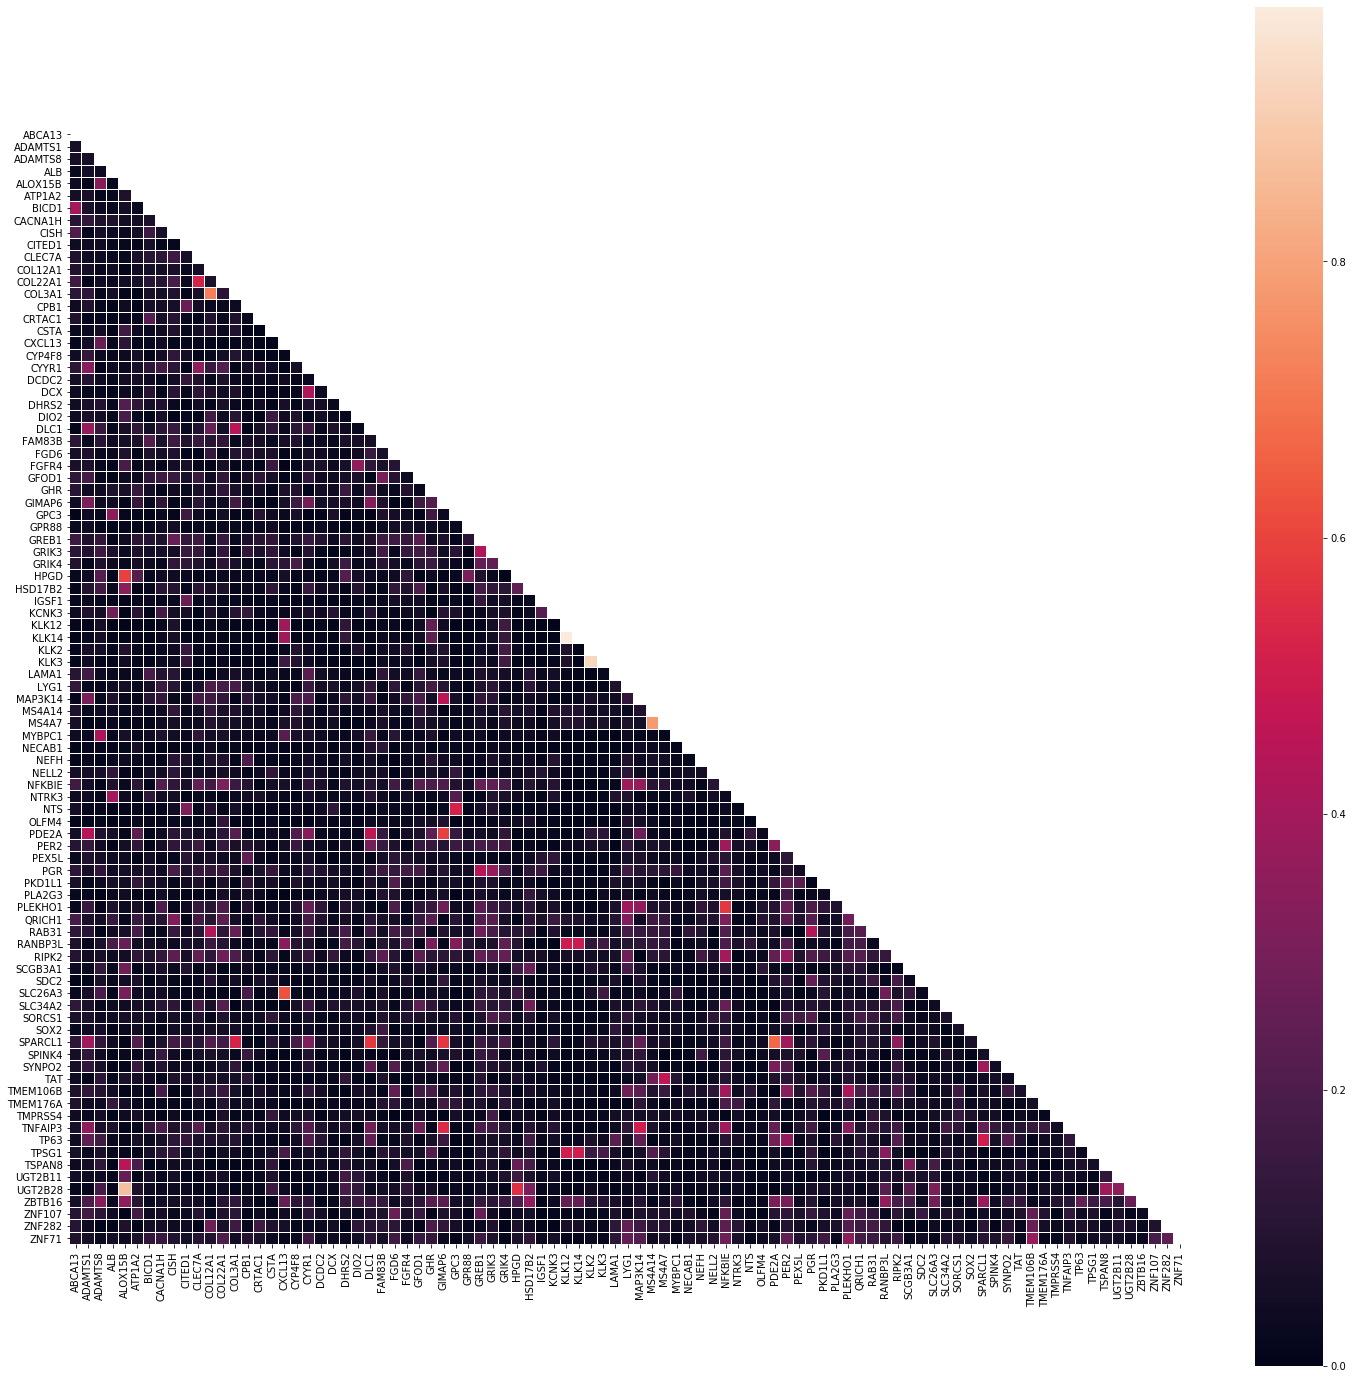

In [16]:
plot_corr(patients_corr, genes_expressed, "corr_patients")

We observe that most of the genes are rather uncorrelated, which gives us a hint of their linear independence.

Now let's look at the pairs of genes which are highly correlated. We define our threshold to be...

In [62]:
CORR_THRESHOLD

0.55

In [63]:
patients_genes_corr = patients_corr[patients_corr > CORR_THRESHOLD].stack()

In [64]:
patients_genes_corr.index = patients_genes_corr.index.tolist()
patients_genes_corr.name = "patients_correlation"

In [55]:
series = []

for h in HORMONES:
    # get all genes expressing hormone h
    genes_h = genes_list[genes_list[h]]
    glist = list(genes_h.genes)

    num_genes = len(glist)

    # Compute pairs of indices for the lower triangular part of a matrix
    # of size (num_genes x num_genes), excluding the diagonal
    # (we don't want to pair the genes to themselves)
    tril_indices = np.tril_indices(num_genes, k=-1)
    index_pairs = list(zip(tril_indices[0], tril_indices[1]))

    # We map the list of index-pairs to all possible pairs of genes
    pairs = [(glist[pair[0]], glist[pair[1]]) for pair in index_pairs]

    # idx = pd.MultiIndex.from_tuples(genes_pairs)
    series_h = pd.Series(data=h, index=pairs, name="pdx_hormone")
    series.append(series_h)
    
genes_pairs = pd.concat(series, sort=False).groupby(level=0).apply(list)

In [65]:
genes_matches = genes_pairs[genes_pairs.index.isin(patients_genes_corr.index)]

In [66]:
patients_genes_corr.sort_values(ascending=False, inplace=True)
patients_genes_corr

(KLK14, KLK12)        0.984432
(KLK3, KLK2)          0.933312
(UGT2B28, ALOX15B)    0.871196
(MS4A7, MS4A14)       0.781378
(COL3A1, COL12A1)     0.719737
(SPARCL1, PDE2A)      0.671257
(SLC26A3, CXCL13)     0.628684
(HPGD, ALOX15B)       0.589839
(PDE2A, GIMAP6)       0.588732
(PLEKHO1, NFKBIE)     0.574771
(SPARCL1, DLC1)       0.573038
(SPARCL1, GIMAP6)     0.571978
(UGT2B28, HPGD)       0.556026
Name: patients_correlation, dtype: float64

In [67]:
(
    pd.DataFrame(patients_genes_corr)
    .join(genes_matches)
)

,patients_correlation,pdx_hormone
"(KLK14, KLK12)",0.984432,[e2]
"(KLK3, KLK2)",0.933312,[dht]
"(UGT2B28, ALOX15B)",0.871196,[dht]
"(MS4A7, MS4A14)",0.781378,[e2]
"(COL3A1, COL12A1)",0.719737,[dht]
"(SPARCL1, PDE2A)",0.671257,[p4]
"(SLC26A3, CXCL13)",0.628684,"[dht, p4]"
"(HPGD, ALOX15B)",0.589839,[dht]
"(PDE2A, GIMAP6)",0.588732,[p4]
"(PLEKHO1, NFKBIE)",0.574771,[dht]


Let us now analyze the second set of patient data.

In [45]:
patients2_corr = patients2.corr()
patients2_corr = df_to_tril(patients2_corr)

In [46]:
patients2_genes_corr = patients2_corr[patients2_corr > CORR_THRESHOLD].stack()

In [47]:
patients2_genes_corr.index = patients2_genes_corr.index.tolist()
patients2_genes_corr.name = "patients2_correlation"

In [48]:
genes_matches = genes_pairs[genes_pairs.index.isin(patients2_genes_corr.index)]

In [49]:
patients2_genes_corr.sort_values(ascending=False, inplace=True)
patients2_genes_corr

(KLK14, KLK12)        0.975478
(MYBPC1, ATP1A2)      0.861628
(SYNPO2, ATP1A2)      0.839422
(SYNPO2, MYBPC1)      0.824060
(PDE2A, GIMAP6)       0.779010
(UGT2B28, ALOX15B)    0.766995
(PDE2A, GHR)          0.761749
(MS4A7, MS4A14)       0.755502
(KLK3, KLK2)          0.745600
(PDE2A, DLC1)         0.743580
(SPARCL1, PDE2A)      0.741066
(COL3A1, COL12A1)     0.723924
(SPARCL1, GIMAP6)     0.696268
(DLC1, ADAMTS1)       0.676533
(SPARCL1, DLC1)       0.660314
(GHR, DLC1)           0.641009
(ZBTB16, PDE2A)       0.636432
(HPGD, ALOX15B)       0.635834
(PDE2A, ADAMTS1)      0.630073
(SPARCL1, CYYR1)      0.626837
(SPARCL1, ADAMTS1)    0.604069
(UGT2B28, HPGD)       0.584766
(TP63, PER2)          0.578773
(PLEKHO1, NFKBIE)     0.577753
(ZBTB16, GHR)         0.574125
(GIMAP6, DLC1)        0.570501
(GIMAP6, GHR)         0.566147
(PDE2A, CYYR1)        0.556835
Name: patients2_correlation, dtype: float64

In [50]:
(
    pd.DataFrame(patients2_genes_corr)
    .join(genes_matches)
)

,patients2_correlation,pdx_hormone
"(KLK14, KLK12)",0.975478,[e2]
"(MYBPC1, ATP1A2)",0.861628,[dht]
"(SYNPO2, ATP1A2)",0.839422,NaN
"(SYNPO2, MYBPC1)",0.824060,[p4]
"(PDE2A, GIMAP6)",0.779010,[p4]
"(UGT2B28, ALOX15B)",0.766995,[dht]
"(PDE2A, GHR)",0.761749,NaN
"(MS4A7, MS4A14)",0.755502,[e2]
"(KLK3, KLK2)",0.745600,[dht]
"(PDE2A, DLC1)",0.743580,[p4]


There appear to be even more correlations in the second patients dataset that match the PDX data. Note that `NaN` means the two genes showed expressions from different hormone treatments in the PDX experiment, i.e. the correlation does not match the PDX results.

Since we have way more matching genes in the second dataset, can we therefore conclude that we can expect better/consistent results for this dataset when we run the methods trained on the PDX data?

***
Let's now analyze the distribution of the features (genetic expressions). Do we observe anything abnormal about the distributions? Will we detect outliers? How will we handle them?

In [ ]:
plot_feature_distributions(patients, genes_expressed)

In [ ]:
# todo: analyze distributions, decide what to do with outliers

***
**Feature processing**
***

Let's try to reduce the dimensionality of the input space, i.e. the linear mapping of our D-dimensional input into a K-dimensional space K<=D that best represents the original data.

In [ ]:
# PCA decomposition of original gene list
# we want to verify that the pre-selected genes are linearly independent

pca = PCA()
pca.fit(pdx)
PCA(copy=True, iterated_power='auto', svd_solver='auto', tol=0.0, whiten=False)

y_pos = np.arange(len(pca.singular_values_))
plt.bar(y_pos, pca.singular_values_, align='center', alpha=0.5)
plt.ylabel('Values')
plt.xlabel('Principal components')
plt.title('PCA - Singular values')
plt.show()

y_pos = np.arange(len(pca.singular_values_))
plt.bar(y_pos, pca.explained_variance_, align='center', alpha=0.5)
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.title('PCA - explained variance')
plt.show()

In [ ]:
# plot data explained by 2nd and 3rd principal component
pca.n_components = 3
X_reduced = pca.fit_transform(pdx)
X_reduced = np.append(X_reduced, pdx.label.values.reshape((33,1)), axis=1)
plt.plot(X_reduced[0:3,1], X_reduced[0:3,2], 'ro')
plt.plot(X_reduced[3:14,1], X_reduced[3:14,2], 'bo')
plt.plot(X_reduced[14:23,1], X_reduced[14:23,2], 'co')
plt.legend(['dht', 'p4', 'e2'])
#plt.plot(X_reduced[23:,1], X_reduced[24:,2], 'yo')
#plt.legend(['dht', 'p4', 'e2', 'ctrl'])
plt.xlabel('2nd PC')
plt.ylabel('3rd PC')
plt.show()

In [ ]:
# interactive 3D plot of first 3 principal components

# uncomment below line to have interactive plot!
# %matplotlib notebook

pca.n_components = 3
X_reduced = pca.fit_transform(pdx)
labels = pdx.label.values.reshape((33,1))
X_reduced = np.append(X_reduced, labels, axis=1)
fig = plt.figure()
ax = plt.axes(projection='3d')
Axes3D.scatter(ax, X_reduced[:3,0], X_reduced[:3,1], X_reduced[:3,2])
Axes3D.scatter(ax, X_reduced[3:14,0], X_reduced[3:14,1], X_reduced[3:14,2])
Axes3D.scatter(ax, X_reduced[14:23,0], X_reduced[14:23,1], X_reduced[14:23,2])
#Axes3D.scatter(ax, X_reduced[23:,0], X_reduced[23:,1], X_reduced[23:,2])
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
ax.legend(['dht', 'p4', 'e2'])
#ax.legend(['dht', 'p4', 'e2', 'ctrl'])

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)

pca = PCA()
pca.fit(pdx)

fig, ax = plt.subplots()
xi = np.arange(0, 33, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.3,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 33, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.axhline(y=0.95, color='orange', linestyle='-')

plt.text(0.5, 1, '99% cut-off threshold', color = 'red', fontsize=10)
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'orange', fontsize=10)

ax.grid(axis='x')
plt.show()

print(pca.n_components_)

***
**Clustering**
***

In [ ]:
X = pdx.drop("label", axis=1)
pdx_labeled = pdx.label

clus = cluster.AgglomerativeClustering(n_clusters=4)  # , affinity='manhattan', linkage='average')
predicted = clus.fit_predict(X)

# calculate score
score = metrics.adjusted_rand_score(pdx_labeled, predicted)
print(score)
# accuracy, f2 = performance(predicted)

***
**Spectral Clustering**
***

In [ ]:
clustering = cluster.SpectralClustering(assign_labels="discretize", random_state=0).fit(X)
print("predicted labels : " + str(clustering.labels_))
print("true labels :      " + str(pdx_labeled.values))
print("Score : " + str(metrics.adjusted_rand_score(pdx_labeled, clustering.labels_)))

***
**K-Means**
***

In [ ]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(X)
print("predicted labels : " + str(kmeans.labels_))
print("true labels :      " + str(pdx_labeled.values))
print("Score : " + str(metrics.adjusted_rand_score(pdx_labeled, kmeans.labels_)))

In [ ]:
# we should rather evaluate with the metrics.adjusted_rand_score function 

def performance(labels):
    '''Evaluate performance of predicted cluster compared to pre-selected gene list'''
    # get gene list
    geneNP = genes_list.loc[:,'dht':'p4'].astype(int).values  # replace with Boolean values
    
    nb_clusters = len(np.unique(labels))
    accuracy = np.zeros([nb_clusters, 3])
    f2 =  np.zeros([nb_clusters, 3])
    beta = 2
    for i in np.arange(nb_clusters):
        label = np.zeros_like(labels)
        label[labels == i] = 1
        for j in np.arange(geneNP.shape[1]):
            # plot confusion matrices
            
            #cm = metrics.confusion_matrix(geneNP[:,j], label)
            #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            #fig, ax = plt.subplots()
            #im = ax.imshow(cm, interpolation='nearest')
            #ax.figure.colorbar(im, ax=ax)
            accuracy[i,j] = np.mean(geneNP[:,j]==label)
            f2[i,j] = metrics.fbeta_score(geneNP[:,j], label, beta)
    return accuracy, f2
        

***
**Principal Component Analysis**
***